<a href="https://colab.research.google.com/github/arnavpanda0/Mushroom-ai-final/blob/main/Data_Preprocessing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ===============================================
# Clean → Encode → Classify (KNN) — Simplified
# ===============================================
# Dataset: Kaggle "Mushroom Classification"
# Expected file: ./mushrooms.csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer  # used ONCE as an example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [8]:
# -----------------------------
# 0) Load data
# -----------------------------
csv_path = "mushrooms.csv"   # TODO: place the file or change path
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path} — download from Kaggle and try again.")

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
# TODO: Get the top 5 rows (1 line of code)


Initial shape: (8124, 23)


In [9]:
# -----------------------------
# 1) Basic cleaning (duplicates, empty rows)
# -----------------------------
before = df.shape[0]

# TODO: Remove duplicates (1 line of code)
df.drop_duplicates(inplace=True)

print("Removed duplicates:", before - df.shape[0])


before = df.shape[0]
# TODO: Drop fully empty rows (1 line of code)
df.dropna

print("Dropped fully empty rows:", before - df.shape[0])

print("\nMissing values per column (top 10):")
# TODO: Display the missing values per column (1 line of code)
df.isna().sum()


Removed duplicates: 0
Dropped fully empty rows: 0

Missing values per column (top 10):


,0
class,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0


In [10]:
# -----------------------------
# 2) Target & split
# -----------------------------
TARGET_COL = "class"
# TODO: change if your label column differs
if TARGET_COL not in df.columns:
    raise ValueError("Update TARGET_COL to match your dataset's label column.")

# TODO: Drop the target column from the "X" (1 line of code)
X = df.drop(columns=[TARGET_COL])
# TODO: Set up the target column (1 line of code)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Detect types BEFORE imputation/encoding
# TODO: Extract the numeric columns from the training data set and store it as a list
# TODO: Extract the categorical columns from the training data set and store it as a list


# Detect types BEFORE imputation/encoding
orig_numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
orig_categorical_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

print("Original numeric cols:", orig_numeric_cols if orig_numeric_cols else "None")
print("Original categorical cols (sample):", orig_categorical_cols[:10])



Train/Test shapes: (6499, 22) (1625, 22)
Original numeric cols: None
Original categorical cols (sample): ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape']


In [15]:
# --------------------------------------------
# 3) IMPUTATION (MANUAL) + one sklearn example
# --------------------------------------------
# copies
X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

# a) numeric → median
num_cols = X_train_imp.select_dtypes(include=['number']).columns
for col in num_cols:
    median_val = X_train_imp[col].median()
    X_train_imp[col] = X_train_imp[col].fillna(median_val)
    X_test_imp[col]  = X_test_imp[col].fillna(median_val)

# b) categorical → mode
cat_cols = X_train_imp.select_dtypes(exclude=['number']).columns
for col in cat_cols:
    mode_val = X_train_imp[col].mode().iloc[0]
    X_train_imp[col] = X_train_imp[col].fillna(mode_val)
    X_test_imp[col]  = X_test_imp[col].fillna(mode_val)

# c) sklearn example on a single categorical col
IMPUTE_EXAMPLE_COL = "odor"  # change if needed
if IMPUTE_EXAMPLE_COL in X_train_imp.columns:
    cat_imp = SimpleImputer(strategy="most_frequent")
    # use .loc[...] or .ravel()
    X_train_imp.loc[:, IMPUTE_EXAMPLE_COL] = cat_imp.fit_transform(
        X_train_imp[[IMPUTE_EXAMPLE_COL]]
    )
    X_test_imp.loc[:, IMPUTE_EXAMPLE_COL] = cat_imp.transform(
        X_test_imp[[IMPUTE_EXAMPLE_COL]]
    )
    print(f"\nUsed sklearn SimpleImputer on column: {IMPUTE_EXAMPLE_COL}")
else:
    print(f"\n[Note] Example imputer column '{IMPUTE_EXAMPLE_COL}' not found. Skipping sklearn example.")



Used sklearn SimpleImputer on column: odor


In [17]:
# --------------------------------------------
# 4) ENCODING
#    - EXPLICIT One-Hot Encoding on ONE chosen column
#    - Then get_dummies for the remaining categoricals
# --------------------------------------------
# Choose the column for explicit OHE:
EXPLICIT_OHE_COL = "odor"  # TODO: change if needed

X_train_enc = X_train_imp.copy()
X_test_enc  = X_test_imp.copy()

if EXPLICIT_OHE_COL in X_train_enc.columns:
    # EXPLICIT OHE on this ONE column — fit on TRAIN only and TEST only separately (2 lines of code)
    train_ohe = pd.get_dummies(X_train_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)
    test_ohe  = pd.get_dummies(X_test_enc[EXPLICIT_OHE_COL],  prefix=EXPLICIT_OHE_COL)

    # Align test columns to train (avoid unseen-category issues)
    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

    # Drop original column and concat OHE columns
    X_train_enc = pd.concat([X_train_enc.drop(columns=[EXPLICIT_OHE_COL]), train_ohe], axis=1)
    X_test_enc  = pd.concat([X_test_enc.drop(columns=[EXPLICIT_OHE_COL]),  test_ohe], axis=1)

    print(f"\nExplicit OHE applied to column: {EXPLICIT_OHE_COL}")
else:
    print(f"\n[Note] Explicit OHE column '{EXPLICIT_OHE_COL}' not found. Skipping explicit OHE step.")

# TODO: Identify remaining categorical columns (post explicit OHE drop) in the TRAINING data set only (1 line of code)
remaining_cat_cols = X_train_enc.select_dtypes(exclude=['number']).columns

# TODO: Apply get_dummies to the remaining categoricals (fit on TRAIN, align TEST) (1 lines of code)
X_train_enc = pd.get_dummies(X_train_enc, columns=remaining_cat_cols)
X_test_enc  = pd.get_dummies(X_test_enc,  columns=remaining_cat_cols)

# Align test columns to train columns (VERY IMPORTANT)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)



Explicit OHE applied to column: odor
Encoded train shape: (6499, 126)
Encoded test shape: (1625, 126)


In [ ]:
# --------------------------------------------
# 5) NORMALIZE numeric columns (if any)
#    (Scale ONLY the original numeric columns; don't scale one-hot columns)
# --------------------------------------------
# TODO: Use the Standard Scaler to scale the numeric values (1 line of code)
from sklearn.preprocessing import StandardScaler

numeric_cols_to_scale = [c for c in orig_numeric_cols if c in X_train_enc.columns]

# TODO: Fit the scaler and scale the train and test data separately. (3 lines of code)
scaler = StandardScaler()
X_train_enc[numeric_cols_to_scale] = scaler.fit_transform(X_train_enc[numeric_cols_to_scale])
X_test_enc[numeric_cols_to_scale]  = scaler.transform(X_test_enc[numeric_cols_to_scale])

# TODO: Print the names of the columns scaled if any (4 lines of code at max)
if numeric_cols_to_scale:
    print("Scaled numeric columns:", numeric_cols_to_scale)
else:
    print("No numeric columns to scale.")


In [22]:
# --------------------------------------------
# 6) KNN + Grid Search
# --------------------------------------------
# TODO: Use the KNN Classifier to classify the data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# TODO: Test for number of neighbors in the set [3, 5, 7, 9, 11, 15, 21]
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

# TODO: Try both the types of weights
# TODO: Also try Manhattan and Euclidean distances.
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)

grid.fit(X_train_enc, y_train)

# Find and print the best_estimator_ and print the best parameters
# Roughly 7 - 9 lines of code including printing the
print("Best estimator:", grid.best_estimator_)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)



Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 1.0



Test accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



<Figure size 640x480 with 0 Axes>

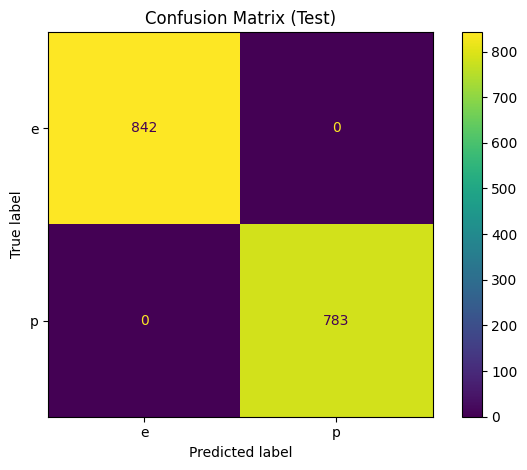

In [19]:
# --------------------------------------------
# 7) Evaluate on held-out TEST
# --------------------------------------------
# TODO: Use KNN to make predictions on the test dataset (1 line of code)
y_pred = grid.best_estimator_.predict(X_test_enc)

test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(test_acc))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


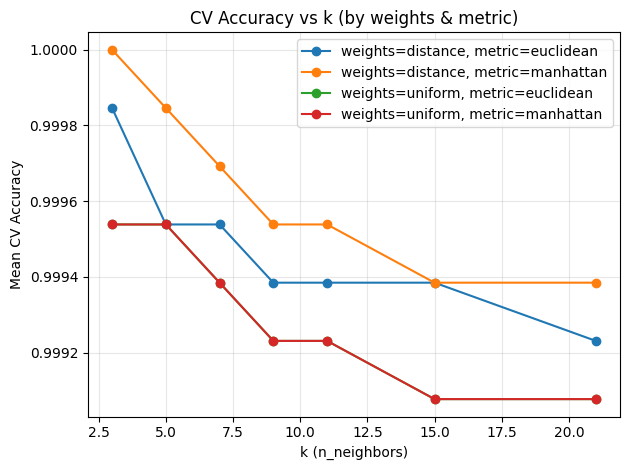

In [21]:
# --------------------------------------------
# 8) Validation curve (CV accuracy vs k)
# --------------------------------------------
#creator note: only changed varible names to match up to code.
cvres = pd.DataFrame(grid.cv_results_)
plotdf = cvres[["param_n_neighbors", "param_weights", "param_metric", "mean_test_score"]].rename(
    columns={"param_n_neighbors":"k", "param_weights":"weights", "param_metric":"metric"}
)

plt.figure()
for (w, m), sub in plotdf.groupby(["weights", "metric"]):
    sub = sub.sort_values("k")
    plt.plot(sub["k"], sub["mean_test_score"], marker="o", label=f"weights={w}, metric={m}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs k (by weights & metric)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


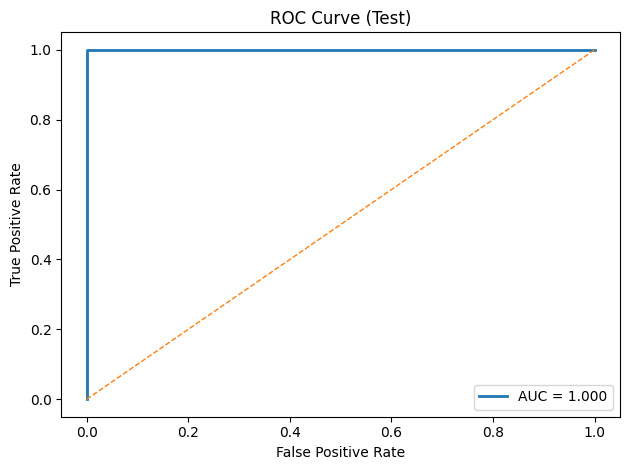

In [24]:
# --------------------------------------------
# 9) ROC curve (binary; micro-average if multiclass)
# --------------------------------------------
#creator note: only changed varible names to match up to code.
best_knn = grid.best_estimator_

if hasattr(best_knn, "predict_proba"):
    classes_ = np.unique(y_train)
    y_test_enc_int = pd.Categorical(y_test, categories=classes_).codes
    proba = best_knn.predict_proba(X_test_enc)

    if len(classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test_enc_int, proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Test)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        y_bin = label_binarize(y_test_enc_int, classes=range(len(classes_)))
        fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"Micro-average AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Micro-average)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


In [26]:
# --------------------------------------------
# 10) Print summary of features
# Sample Output: Final feature count: 25
# Best KNN: KNeighborsClassifier(n_neighbors=7, p=2, weights='distance')
# --------------------------------------------
# TODO: Print the final stats (2 lines of code)

print(f"Final feature count: {X_train_enc.shape[1]}")
print("Best KNN:", grid.best_estimator_)


Final feature count: 126
Best KNN: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
